In [317]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy import stats

import xgboost as xgb

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv
/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv


In [318]:
R_STATE = 33

In [319]:
def standardize_features(train_data: pd.DataFrame,test_data: pd.DataFrame, feature_names: list):
    """Standardizes numerical features and returns the scaler and standardized train and test dataframes"""
    scaler = StandardScaler()
    df_copy , test_df = train_data.copy(), test_data.copy()
    df_copy[feature_names] = scaler.fit_transform(df_copy[feature_names])
    test_df[feature_names] = scaler.transform(test_df[feature_names])
    
    return scaler, df_copy, test_df

In [320]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
real = pd.read_csv('/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv')

In [321]:
real

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0
...,...,...,...,...,...,...,...
74,1.025,7.90,721,23.6,301,9.04,1
75,1.017,4.81,410,13.3,195,0.58,1
76,1.024,5.40,803,21.8,394,7.82,1
77,1.016,6.81,594,21.4,255,12.20,1


In [322]:
train

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...,...
409,409,1.011,5.21,527,21.4,75,1.53,0
410,410,1.024,5.53,577,19.7,224,0.77,0
411,411,1.018,6.28,455,22.2,270,7.68,1
412,412,1.008,7.12,325,12.6,75,1.03,1


In [323]:
train.info(), train.target.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


(None,
 0    230
 1    184
 Name: target, dtype: int64)

In [324]:
real.info(), real.target.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  79 non-null     float64
 1   ph       79 non-null     float64
 2   osmo     79 non-null     int64  
 3   cond     79 non-null     float64
 4   urea     79 non-null     int64  
 5   calc     79 non-null     float64
 6   target   79 non-null     int64  
dtypes: float64(4), int64(3)
memory usage: 4.4 KB


(None,
 0    45
 1    34
 Name: target, dtype: int64)

In [325]:
predictors = ["gravity", "ph", "osmo", "cond", "urea", "calc"]

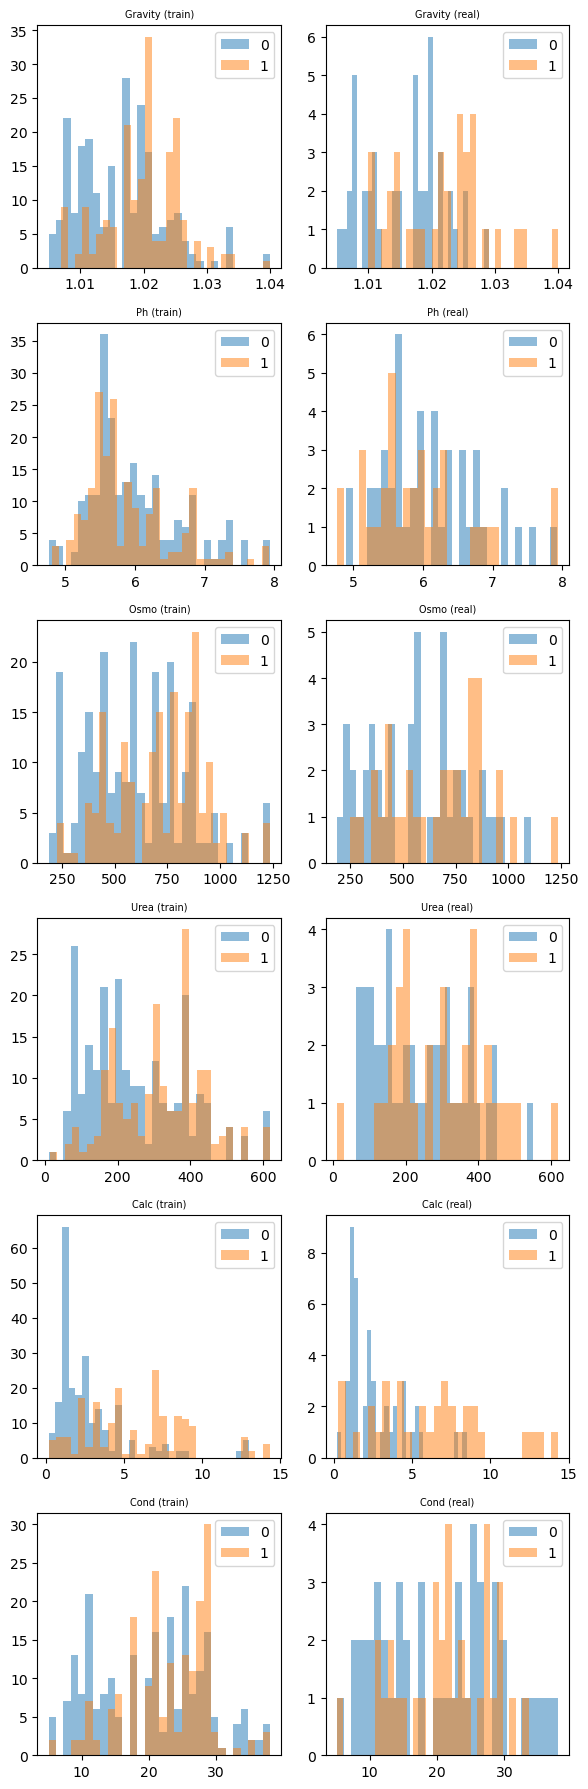

In [326]:
fig, axs = plt.subplots(6, 2, figsize=(6, 18))

df_list = [train, real]

for i, df in enumerate(df_list):
    features = ["gravity", "ph", "osmo", "urea", "calc", "cond"]
    for j, ft in enumerate(features):
        data1 = df[df.target == 0][ft]
        data2 = df[df.target == 1][ft]
        ax1 = axs[j, i]
        ax1.hist(data1, bins=30, alpha=0.5, label='0')
        ax1.hist(data2, bins=30, alpha=0.5, label='1')
        ax1.set_title(
            f"{ft.title()} ({['train', 'real'][i]})", size=7)
        ax1.legend()
plt.tight_layout()
plt.show()


In [327]:
df = pd.concat([train, real], axis=0)
df = df.drop("id", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 0 to 78
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  493 non-null    float64
 1   ph       493 non-null    float64
 2   osmo     493 non-null    int64  
 3   cond     493 non-null    float64
 4   urea     493 non-null    int64  
 5   calc     493 non-null    float64
 6   target   493 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 30.8 KB


### Outliers removal

In [328]:
print("before outlier removal")
prev_len = df.shape[0]
df.describe()

before outlier removal


,gravity,ph,osmo,cond,urea,calc,target
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,1.017929,5.967160,645.344828,21.337931,276.693712,4.118540,0.442191
std,0.006761,0.655861,235.320087,7.579484,135.568157,3.221149,0.497151
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,1.012000,5.530000,450.000000,15.500000,164.000000,1.450000,0.000000
50%,1.018000,5.770000,668.000000,21.900000,272.000000,3.160000,0.000000
75%,1.022000,6.280000,838.000000,27.600000,385.000000,6.630000,1.000000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [329]:
# Calculate the z-scores for the DataFrame
z_scores = np.abs(stats.zscore(df))

# Find the indices of the outliers based on z-scores
outlier_indices = np.where(z_scores > 2.5)[0]

# Remove the outliers from the DataFrame
df = df[~df.index.isin(outlier_indices)]

In [330]:
df.describe()

,gravity,ph,osmo,cond,urea,calc,target
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,1.017442,5.938695,628.997788,21.034292,267.042035,3.727478,0.433628
std,0.006441,0.598698,224.431348,7.672356,126.470106,2.747876,0.496124
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,1.011000,5.530000,443.000000,14.750000,164.000000,1.400000,0.000000
50%,1.018000,5.755000,644.500000,21.400000,255.000000,3.010000,0.000000
75%,1.021000,6.280000,816.750000,27.375000,382.000000,5.540000,1.000000
max,1.034000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [331]:
print(f"{prev_len - df.shape[0]} instances removed")

41 instances removed


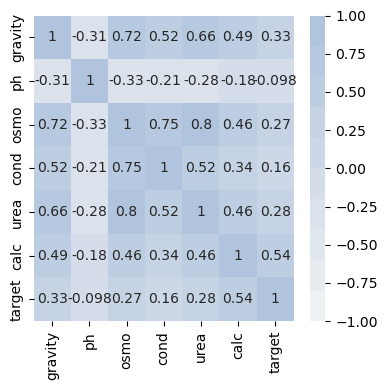

In [332]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, 
                 cmap=sns.light_palette("lightsteelblue",n_colors=10, reverse=False),
                 ax=ax)

plt.tight_layout()
plt.show()

In [333]:
df, df.target.value_counts(normalize=True
                        )

(    gravity    ph  osmo  cond  urea   calc  target
 0     1.013  6.19   443  14.8   124   1.45       0
 1     1.025  5.40   703  23.6   394   4.18       0
 2     1.009  6.13   371  24.5   159   9.04       0
 3     1.021  4.91   442  20.8   398   6.63       1
 4     1.021  5.53   874  17.8   385   2.21       1
 ..      ...   ...   ...   ...   ...    ...     ...
 74    1.025  7.90   721  23.6   301   9.04       1
 75    1.017  4.81   410  13.3   195   0.58       1
 76    1.024  5.40   803  21.8   394   7.82       1
 77    1.016  6.81   594  21.4   255  12.20       1
 78    1.015  6.03   416  12.8   178   9.39       1
 
 [452 rows x 7 columns],
 0    0.566372
 1    0.433628
 Name: target, dtype: float64)

In [334]:
# check for duplicates
duplicates = df.duplicated()
duplicates.sum()

0

### Oversampling the smaller class with smote

In [335]:
sm = SMOTE(random_state=2)
x, y = sm.fit_resample(df, df.target)

In [336]:
df = x
df["target"] = y
df

,gravity,ph,osmo,cond,urea,calc,target
0,1.013000,6.190000,443,14.800000,124,1.450000,0
1,1.025000,5.400000,703,23.600000,394,4.180000,0
2,1.009000,6.130000,371,24.500000,159,9.040000,0
3,1.021000,4.910000,442,20.800000,398,6.630000,1
4,1.021000,5.530000,874,17.800000,385,2.210000,1
...,...,...,...,...,...,...,...
507,1.023947,6.073512,442,20.491221,398,4.381230,1
508,1.021449,6.847374,711,21.481565,403,6.519405,1
509,1.024702,5.251919,703,15.184668,187,0.870409,1
510,1.025970,4.930292,302,11.994006,16,0.382776,1


In [337]:
x_train, x_test, y_train, y_test = train_test_split(df[predictors], df.target, test_size = 0.1)

scaler, x_std , test_std = standardize_features(df[predictors], test, predictors)

x_train_std, x_test_std, y_train_std, y_test_std = train_test_split(x_std, df.target, test_size = 0.1)



In [338]:
x_std

,gravity,ph,osmo,cond,urea,calc
0,-0.738322,0.433488,-0.858089,-0.837956,-1.164582,-0.887674
1,1.174901,-0.911453,0.306442,0.340177,0.982462,0.101487
2,-1.376063,0.331340,-1.180575,0.460668,-0.886261,1.862411
3,0.537160,-1.745656,-0.862568,-0.034683,1.014270,0.989196
4,0.537160,-0.690134,1.072345,-0.436320,0.910894,-0.612304
...,...,...,...,...,...,...
507,1.007077,0.235171,-0.862568,-0.076022,1.014270,0.174398
508,0.608750,1.552638,0.342273,0.056564,1.054030,0.949124
509,1.127392,-1.163554,0.306442,-0.786458,-0.663605,-1.097678
510,1.329558,-1.711110,-1.489623,-1.213620,-2.023399,-1.274362


### Models

In [339]:
lnr = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=6)

In [351]:
lnr.fit(x_train_std, y_train_std)
preds = lnr.predict(x_test_std)

print(classification_report(y_test_std, preds))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82        25
           1       0.85      0.81      0.83        27

    accuracy                           0.83        52
   macro avg       0.83      0.83      0.83        52
weighted avg       0.83      0.83      0.83        52



In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  512 non-null    float64
 1   ph       512 non-null    float64
 2   osmo     512 non-null    int64  
 3   cond     512 non-null    float64
 4   urea     512 non-null    int64  
 5   calc     512 non-null    float64
 6   target   512 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 28.1 KB


In [342]:
xgbc = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate = 0.1,
    reg_alpha= 5,
    #reg_lambda= 1,
    random_state=R_STATE,
    n_jobs=-1,
    objective='binary:logistic',
    eval_metric='logloss',
)

xgbc.fit(x_train_std, y_train_std)
preds_xgb = xgbc.predict(x_test_std)

print(classification_report(y_test_std, preds_xgb))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        25
           1       0.79      0.85      0.82        27

    accuracy                           0.81        52
   macro avg       0.81      0.81      0.81        52
weighted avg       0.81      0.81      0.81        52



In [343]:
def submission_csv(trained_model, test_data, indexes, filename):
    preds = trained_model.predict_proba(test_data)[:, 1]
    df_ = pd.DataFrame(zip(indexes, preds), columns= ["id", "Class"])
    df_.to_csv(f"{filename}.csv", index=False)


In [347]:
submission_csv(lnr, test_std.drop("id", axis=1), range(414, 690), "logistic regression")

In [352]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
import plotly.graph_objs as go 

data = x_train
labels = y_train

tsne = TSNE(n_components=3, random_state=0)
tsne_data = tsne.fit_transform(x_train)


fig = go.Figure(data=[go.Scatter3d(
    x=tsne_data[:,0],
    y=tsne_data[:,1],
    z=tsne_data[:,2],
    mode='markers',
    marker=dict(
        size=8,
        color=labels,
        colorscale='Viridis',
        opacity=0.8
    )
)])


fig.update_layout(
    title=dict(text='3DVisualization of Digits Dataset using TSNE reduction'),
    scene={
        "xaxis_title":'x',
        "yaxis_title":'y',
        "zaxis_title":'z'
    },
)

# Show the plot
fig.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

